In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default") 
%matplotlib inline
from matplotlib import ticker
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker

#file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\df_concat_1H_PYCO2SYS.csv')
file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\df_concat_1H_clean.csv')
df_concat_1H = pd.read_csv(file_path, parse_dates=[0], index_col=[0])

# Change Units of Barometric Pressure  (mbar to dbar)
df_concat_1H['p_dbar_w'] = df_concat_1H['p_rad'] * (0.01)
# Average Air Temperature 
df_concat_1H['t_air_w'] = (df_concat_1H['t_air'] + df_concat_1H['t_rad'])/2
# Change Units of Barometric Pressure  (mbar to atm)
df_concat_1H['p_rad_atm'] = df_concat_1H['p_rad'] / (1013.25)
# Change Units of Barometric Pressure  (mbar to dbar)
df_concat_1H['p_dbar_w'] = df_concat_1H['p_rad'] * (0.01)



df_concat_1H['iH2CO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_H2CO3']
df_concat_1H['iHCO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_HCO3']
df_concat_1H['iCO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_CO3']

# Air T = t_air
# Water T = t_adcp

df_concat_1H.head(5)

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


,ch4_w,ich4_w,co2_w,ico2_w,year,month,day,hour,ε_CO2_H2CO3,iH2CO3,...,sog,cog,J_co2,J_ico2,J_ch4,J_ich4,dT,p_dbar_w,t_air_w,p_rad_atm
date_time,,,,,,,,,,,,,,,,,,,,,
2016-07-23 13:00:00,23.301083,-53.600228,646.058385,-17.661098,2016.0,7,23,13,2.068281,-15.592818,...,10.955399,94.552643,272.276970,-9.486594,21.356761,-1.346473,-14.084204,9.912248,22.416657,0.978263
2016-07-23 14:00:00,39.486946,-52.601761,515.811507,-17.575121,2016.0,7,23,14,2.145055,-15.430066,...,10.474986,114.039650,107.309409,-8.161043,37.561832,-2.027329,-8.971934,9.921584,17.440208,0.979184
2016-07-23 15:00:00,49.098623,-53.047011,399.511807,-17.358765,2016.0,7,23,15,2.263006,-15.095759,...,4.956650,113.458218,-1.185627,-7.859890,47.038441,-0.337663,-8.078016,9.922080,16.867666,0.979233
2016-07-24 04:00:00,47.788052,-52.620257,679.606822,-18.290788,2016.0,7,24,4,2.835428,-15.455360,...,11.162176,318.919852,288.045169,-9.539526,45.791792,-4.336513,-12.089548,9.895092,23.426140,0.976570
2016-07-24 05:00:00,57.168783,-52.312462,657.095412,-18.348634,2016.0,7,24,5,3.090363,-15.258272,...,11.336358,172.060174,280.233873,-10.253880,55.224594,-1.913805,-13.563626,9.895403,25.442350,0.976600


In [ ]:
df_concat_1H.columns

<br><br><br>

# Run PYCO2SYS Program

- Notes
> The use of [dbar] for water pressure. The previous attempt wrongly used atmospheres as the unit of measurement. This may have lead to the high values.

<br>

> Only the pH, Water Temperature, and Water Pressure were used in this prediction. 

##### opt_k_carbonic
- 8: M79 (0 < T < 50 °C, S = 0, freshwater only).
- 9: CW98 (2 < T < 30 °C, 0 < S < 40, NBS scale, real estuarine seawater).
- 15: WMW14 (0 < T < 45 °C, 0 < S < 45, Seawater scale, real seawater).

<br><br><br>

In [3]:
# Import PYCO2SYS
#import PyCO2SYS as pyco2

In [8]:
# Define input conditions
kwargs = dict(par1 = df_concat_1H['co2_w'], # ppm
              par1_type = 9,
              #par2 = ,  
              #par2_type = 3 ,
              salinity = 0,
              temperature = df_concat_1H['t_adcp'],  # Temperature at input conditions (deg_C)
              #pressure= df_concat_1H['p_dbar'], # (dbar)
              pressure_atmosphere = df_concat_1H['p_rad_atm'], # (atm)
              opt_k_carbonic = 8,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
              #opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
              #total_silicate = m2['SiO2'].mean() ,  # (umol/kg)
              #total_ammonia = df_concat_1H['NH4'] ,   # (umol/kg)
              #total_phosphate = df_concat_1H['PO4'],  # mol/kg)
              #total_calcium = merged_df[''] ,    # (umol/kg)
              #total_sulfate = merged_df[''],    # (umol/kg)
              #total_fluoride = merged_df[''] ,    # (umol/kg)
             )

# Run CO2SYS!
#results = pyco2.sys(**kwargs)

# Numpy to Pandas
#df_results = pd.DataFrame.from_dict(results)

In [9]:
#df_results.to_csv('PYCO2SYS_Results_df_concat_1H.csv')

<br><br><br><br><br><br>

# Results

<br><br><br><br><br><br>

In [4]:
file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\PYCO2SYS_Results_df_concat_1H.csv')
df_results = pd.read_csv(file_path)
df_results.columns

Index(['Unnamed: 0', 'par1', 'par1_type', 'opt_k_bisulfate', 'opt_k_carbonic',
       'opt_k_fluoride', 'opt_total_borate', 'opt_gas_constant',
       'opt_pH_scale', 'opt_buffers_mode', 'salinity', 'temperature',
       'pressure', 'total_ammonia', 'total_borate', 'total_calcium',
       'total_fluoride', 'total_phosphate', 'total_silicate', 'total_sulfate',
       'total_sulfide', 'peng_correction', 'gas_constant', 'total_alpha',
       'total_beta', 'pressure_atmosphere', 'pressure_atmosphere_out', 'pCO2',
       'fCO2', 'aqueous_CO2', 'xCO2', 'k_CO2', 'k_carbonic_1', 'k_carbonic_2',
       'k_water', 'k_borate', 'k_bisulfate', 'k_fluoride', 'k_phosphoric_1',
       'k_phosphoric_2', 'k_phosphoric_3', 'k_silicate', 'k_ammonia',
       'k_sulfide', 'k_calcite', 'k_aragonite', 'fugacity_factor', 'vp_factor',
       'fH', 'k_alpha', 'k_beta'],
      dtype='object')

In [49]:
# No Data for 'alkalinity', 'dic', 'bicarbonate', 'carbonate',

df_results = df_results[['aqueous_CO2',  # umol/kg
                         'pCO2', # uatm
                         'fCO2', # uatm
                         'xCO2', # ppm
                         'k_CO2', # Henry's Constant
                         'k_carbonic_1', # H2CO3 = HCO3
                         'k_carbonic_2', # HCO3 = CO3
                         'gas_constant', # ideal gas constant  (1/mbar·mol·K)
                        ]]

In [50]:
df_results.head(5)

,aqueous_CO2,pCO2,fCO2,xCO2,k_CO2,k_carbonic_1,k_carbonic_2,gas_constant
0,40.469134,718.720212,715.898583,726.667792,0.056529,3.319478e-07,3.104689e-11,83.144626
1,34.492334,611.288616,608.886868,618.020330,0.056648,3.314777e-07,3.099107e-11,83.144626
2,32.188714,572.244097,569.998374,578.584637,0.056472,3.321760e-07,3.107399e-11,83.144626
3,26.037464,466.111510,464.287044,471.347207,0.056081,3.337311e-07,3.125911e-11,83.144626
4,21.677341,394.919406,393.383759,399.511807,0.055105,3.376692e-07,3.173060e-11,83.144626


In [51]:
df_concat_1H['aqueous_CO2'] = df_results['aqueous_CO2']
df_concat_1H['pCO2'] = df_results['pCO2']
df_concat_1H['k_CO2'] = df_results['k_CO2']

In [52]:
df_concat_1H.head(3)

,ch4_w,ich4_w,co2_w,ico2_w,year,month,day,hour,ε_CO2_H2CO3,iH2CO3,...,cog,J_co2,J_ico2,J_ch4,J_ich4,dT,p_dbar_w,aqueous_CO2,pCO2,k_CO2
date_time,,,,,,,,,,,,,,,,,,,,,
2016-07-23 13:00:00,23.301083,-53.600228,646.058385,-17.661098,2016.0,7,23,13,2.068281,-15.592818,...,94.552643,272.276970,-9.486594,21.356761,-1.346473,-14.084204,9.912248,NaN,NaN,NaN
2016-07-23 14:00:00,39.486946,-52.601761,515.811507,-17.575121,2016.0,7,23,14,2.145055,-15.430066,...,114.039650,107.309409,-8.161043,37.561832,-2.027329,-8.971934,9.921584,NaN,NaN,NaN
2016-07-23 15:00:00,49.098623,-53.047011,399.511807,-17.358765,2016.0,7,23,15,2.263006,-15.095759,...,113.458218,-1.185627,-7.859890,47.038441,-0.337663,-8.078016,9.922080,NaN,NaN,NaN


In [53]:
df_concat_1H.columns

Index(['ch4_w', 'ich4_w', 'co2_w', 'ico2_w', 'year', 'month', 'day', 'hour',
       'ε_CO2_H2CO3', 'iH2CO3', 'ε_CO2_HCO3', 'iHCO3', 'ε_CO2_CO3', 'iCO3',
       'ch4_a', 'ich4_a', 'co2_a', 'ico2_a', 'lon_a', 'year.1', 'month.1',
       'day.1', 'hour.1', 'lat', 'lon', 'u', 'u_dir', 'swr', 'lwr', 'rh',
       't_air', 't_dew', 't_adcp', 't_rad', 'p_rad', 'sog', 'cog', 'J_co2',
       'J_ico2', 'J_ch4', 'J_ich4', 'dT', 'p_dbar_w', 'aqueous_CO2', 'pCO2',
       'k_CO2'],
      dtype='object')

In [54]:
df = df_concat_1H[['lat', 'lon', 't_adcp', 'p_rad',
                    'co2_w', 'ico2_w', 'co2_a', 'ico2_a',
                    'ch4_w', 'ich4_w', 'ch4_a', 'ich4_a',
                    'iH2CO3', 'iHCO3', 'iCO3', 'J_co2']]

df.index = df_concat_1H.index

# Transect I
df1 = df.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df2 = df.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00'] 

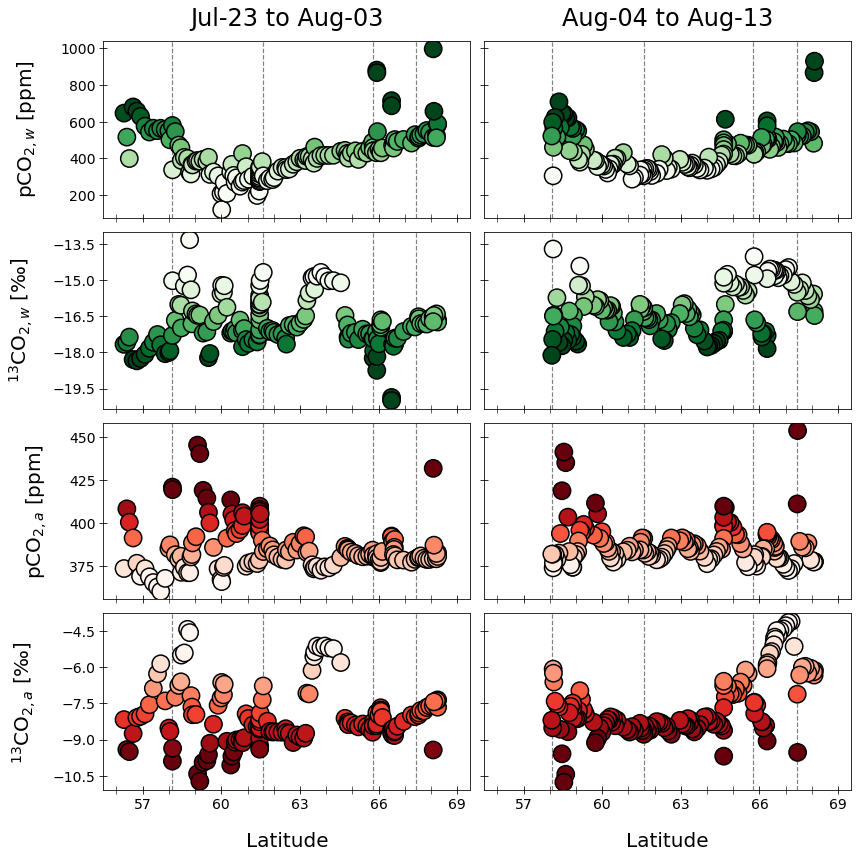

In [56]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")


ax[0,0].scatter(df1['lat'], df1['co2_w'], cmap = 'Greens', c = df1['co2_w'], ec='black',
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df1['co2_w'].quantile(0.05), 
                vmax=df1['co2_w'].quantile(0.95))

ax[1,0].scatter(df1['lat'], df1['ico2_w'], cmap = 'Greens_r', c = df1['ico2_w'], ec='black',
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1['ico2_w'].quantile(0.05), 
                vmax=df1['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1['lat'], df1['co2_a'], cmap = 'Reds', c = df1['co2_a'], ec='black',
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df1['co2_a'].quantile(0.05), 
                vmax=df1['co2_a'].quantile(0.95))

ax[3,0].scatter(df1['lat'], df1['ico2_a'], cmap = 'Reds_r', c = df1['ico2_a'], ec='black',
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1['ico2_a'].quantile(0.05), 
                vmax=df1['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2['lat'], df2['co2_w'], cmap = 'Greens', c = df2['co2_w'], ec='black',
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df2['co2_w'].quantile(0.05), 
                vmax=df2['co2_w'].quantile(0.95))

ax[1,1].scatter(df2['lat'], df2['ico2_w'], cmap = 'Greens_r', c = df2['ico2_w'], ec='black',
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2['ico2_w'].quantile(0.05), 
                vmax=df2['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2['lat'], df2['co2_a'], cmap = 'Reds', c = df2['co2_a'], ec='black',
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df2['co2_a'].quantile(0.05), 
                vmax=df2['co2_a'].quantile(0.95))

ax[3,1].scatter(df2['lat'], df2['ico2_a'], cmap = 'Reds_r', c = df2['ico2_a'], ec='black',
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2['ico2_a'].quantile(0.05), 
                vmax=df2['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

#ax[0,0].set_ylim(-50,2000)
#ax[2,0].set_ylim(350,480)
#ax[1,0].set_ylim(-21,-11)
#ax[3,0].set_ylim(-13,-3)

#ax[0,1].set_ylim(-50,2000)
#ax[2,1].set_ylim(350,480)
#ax[1,1].set_ylim(-21,-11)
#ax[3,1].set_ylim(-13,-3)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1.2, zorder=0) # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1.2, zorder=0) # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1.2, zorder=0) # NT
    ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.tight_layout(pad=1)

#fig.savefig('Clean_Yenisei_2016_1H_co2_ico2_latitude.png', dpi = 500, bbox_inches='tight')

In [58]:
df2['ico2_w'].min()

-18.116487666